In [1]:
#!pip install opencv-python
#!apt-get update ##[edited]
#!apt-get install ffmpeg libsm6 libxext6  -y

In [13]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import s3fs
import numpy as np
import boto3
import cv2

In [14]:
fs = s3fs.S3FileSystem()

# To List 5 files in your accessible bucket
images = fs.ls('s3://sxm-ecommerce-p66-location-data/version2/training_images/')
print(len(images))
#images = (images[-2190:])
#print((images))

100


In [15]:
# Get coords from s3 file
client = boto3.client('s3')
path = 's3://sxm-ecommerce-p66-location-data/coords/100_coords.csv'
df = pd.read_csv(path)
df.drop('location_id', axis=1, inplace=True)
df.drop('merchant_location_id', axis=1, inplace=True)
df.sort_values(by=['merchant_location_latitude'], inplace=True)
df.to_csv('sorted_csv.csv', encoding='utf-8', index=False)

In [16]:
df = pd.read_csv('sorted_csv.csv')
# df = df.drop(df.index[range(691)])
df.head()

,merchant_location_latitude,merchant_location_longitude
0,21.331533,-157.865814
1,28.782888,-97.045563
2,29.449435,-95.078111
3,29.617713,-95.564214
4,30.166849,-81.748018


In [17]:
def scale_colors(uniqueColor, maxColor, minColor):    
    for color_idx in argSortedCounts[-numColors:]:
        color = uniqueColor[color_idx]
        R = color[0]
        G = color[1]
        B = color[2]
        maxColor = scale_max_color(maxColor, R, G, B)
        minColor = scale_min_color(minColor, R, G, B)

def scale_max_color(maxColor, R, G, B):
    if R > maxColor[0]:
            maxColor[0] = R
    if G > maxColor[1]:
            maxColor[1] = G
    if B > maxColor[2]:
            maxColor[2] = B
    return maxColor
                
def scale_min_color(minColor, R, G, B):
    if R < minColor[0]:
        minColor[0] = R
    if G < minColor[1]:
        minColor[1] = G
    if B < minColor[2]:
        minColor[2] = B
    return minColor

In [18]:
def boost_contrast(i, minColor, maxcolor):
    iContrast = np.zeros(i.shape)
    iContrast = (i - minColor) * 255 / (maxColor - minColor)        
    return iContrast

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(600, 600)
(600, 600)
(600, 600)
(600, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(600, 600)
(600, 600)
(600, 600)
(600, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(600, 600)
(600, 600)
(600, 600)
(600, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(600, 600)
(600, 600)
(600, 600)
(600, 600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(600, 600)
(600, 600)
(600, 600)
(600, 600)


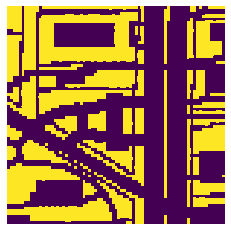

In [23]:
img_num = 0
for image in images[:5]:
    with fs.open(image) as f:
        i = plt.imread(f, 0)
        plt.imshow(i)
        flatImage = np.reshape(i, (i.shape[0]*i.shape[1], i.shape[2]))
        
        uniqueColor, counts = np.unique(flatImage, axis=0, return_counts=True)
        sortedCounts = np.sort(counts)
        argSortedCounts = np.argsort(counts)
        
        kernelO = np.ones((5, 5), np.uint8)
        
        numColors = 4
        maxColor = np.zeros(3)
        minColor = np.array([255, 255, 255])
        scale_colors(uniqueColor, maxColor, minColor)

        contrast = boost_contrast(i, minColor, maxColor)
        plt.imshow(contrast)
        #plt.show()
        
        num = 0
        for color_idx in argSortedCounts[-numColors:]:
            #print(num)
            num += 1
            color = uniqueColor[color_idx]
            
            colorImage = i == color

            stacked = np.sum(colorImage, axis=2)
            stacked = stacked >= 3
            stacked = np.asarray(stacked, dtype=float)
            opened = cv2.morphologyEx(stacked, cv2.MORPH_OPEN, kernelO)

            lat_coords = df['merchant_location_latitude'].values[img_num]
            long_coords = df['merchant_location_longitude'].values[img_num]
#             plt.imshow(opened)
#             print(opened.shape)
#             plt.title('%f, %f_Freq:%i' % (lat_coords, long_coords, num))
#             plt.axis('off')
#             plt.savefig('data/training_freqs/img_%f, %f_freq_%i.png' % (lat_coords, long_coords, num), bbox_inches='tight')
            plt.imsave('data/training_freqs/img_%f, %f_freq_%i.png' % (lat_coords, long_coords, num), opened)
            #plt.show()
    img_num +=1

In [26]:
import sagemaker


s3_path_to_data = sagemaker.Session().upload_data(bucket='sxm-ecommerce-p66-location-data', 
                                                  path='Geofences/Summer2021/data/training_freqs', 
                                                  key_prefix='version2/training_freqs/')

FileNotFoundError: [Errno 2] No such file or directory: 'Geofences/Summer2021/data/training_freqs'

In [ ]:
#get an array of the s3 bucket where all freqs images are stored
freq_imgs = fs.ls('s3://sxm-ecommerce-p66-location-data/freqs')
freq_imgs.pop(0)
path = freq_imgs
#clean up jargon
freq_imgs = [str(freq).replace( 'sxm-ecommerce-p66-location-data/freqs/img_', '') for freq in freq_imgs]
freq_imgs = [str(freq).replace( '.png', '') for freq in freq_imgs]

In [ ]:
#create csv of all freq images to list if img is road or not
path = np.array(path)
road_or_not = {'img': freq_imgs, 'type': [0] * len(freq_imgs), 'path': path}
road_or_not_df = pd.DataFrame(road_or_not) 
road_or_not_df.to_csv('data/freqs/road_or_building2.csv')

In [11]:
# import os
# files_in_directory = os.listdir()
# filtered_files = [file for file in files_in_directory if file.endswith(".out")]
# for file in filtered_files:
# 	path_to_file = file
# 	os.remove(path_to_file)

In [24]:
image = plt.imread('data/training_freqs/img_21.331533, -157.865814_freq_1_600_600.png', 0)
image.shape

(600, 600, 4)